In [32]:
import sys
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [33]:
from coco.job import Job

In [34]:
current_job = Job.from_name("nyu_depth")

state_run
phase_train


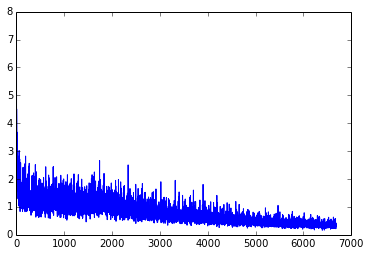

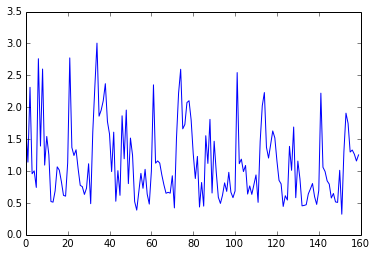

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Refresh job
current_job.load()
data = current_job.data

train_losses = np.array(data["train_losses"]).squeeze()
val_losses = np.array(data["val_losses"]).squeeze()

print data["state"]
print data["phase"]

plt.plot(train_losses)
plt.show()

plt.plot(val_losses)
plt.show()

In [50]:
w = 40

for i in range(0,len(val_losses),w):
    print val_losses[i:i+w].mean()

1.36940763891
1.19563031644
1.07130169347
0.929766634107
